# MLOps Project to Build and Deploy LSTM Model with Sagemaker

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import required libraries

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import os

from sklearn import preprocessing

import lightgbm

import tensorflow as tf
from tensorflow import keras

import utils

### Load data

In many cases, the data is stored in local system. To read the data from the local system, specify the correct path and filename.
 
Comma-separated values, also known as CSV, is a specific way to store data in a table structure format.
The data used in this project is stored in a CSV file.

 
Use following code to read data from csv file using pandas. 
```
import pandas as pd
csv_file_path= "burger_data.csv"
df = pd.read_csv(csv_file_path)
```
With appropriate csv_file_path, pd.read_csv() function will read the data and store it in df variable.
 
If you get *FileNotFoundError or No such file or directory*, try checking the path provided in the function. It's possible that python is not able to find the file or directory at a given location.

In [3]:
#loading the config.yml file
config = yaml.full_load(open("config.yml", "rb"))

In [4]:
#reading data from DB using read_data_from_db function from utils.py file
df = utils.read_data_from_db(config)
df.head()

OperationalError: (2003, "Can't connect to MySQL server on 'myhostaddress.amazonaws.com' ([Errno 11001] getaddrinfo failed)")

In [3]:
csv_file_path= "burger_data.csv"
df = pd.read_csv(csv_file_path)
df.head()

,Date,Region,Temperature,Humidity,Wind,Visibility,Pressure,Sales
0,15-09-2020,Reg1,10.248814,0.779164,11.509130,14.503403,1017.293917,991.60
1,14-09-2020,Reg1,10.337595,0.908549,7.432656,2.232960,1019.452636,1858.59
2,13-09-2020,Reg1,20.763686,0.505324,7.788249,4.779211,1022.677119,3.99
3,12-09-2020,Reg1,21.500892,0.758557,3.767432,9.904534,1009.341357,3090.78
4,11-09-2020,Reg1,21.774269,0.398296,20.705369,15.224605,1015.713234,990.99


In [4]:
#preprocessing the data
df = utils.preprocess_data(df)
df.head(20)

,Date,Region,Temperature,Humidity,Wind,Visibility,Pressure,Sales
0,2014-01-01,Reg1,17.471199,0.753878,6.755839,13.807525,1014.437661,1539.45
1,2014-01-01,Reg10,26.172323,0.627922,2.934502,2.767375,1013.658047,879.40
2,2014-01-01,Reg2,16.919725,0.768124,9.974577,9.930142,1010.770295,2721.81
3,2014-01-01,Reg3,1.028776,0.548461,13.460983,12.265043,1022.632837,2240.22
4,2014-01-01,Reg4,8.070674,0.632359,13.260757,6.628645,1021.706718,468.78
5,2014-01-01,Reg5,15.207547,0.492346,9.643971,7.087097,1023.544923,137.76
6,2014-01-01,Reg6,22.383260,0.467198,10.199793,8.241952,1022.214341,520.35
7,2014-01-01,Reg7,22.161662,0.702788,9.713461,4.519136,1013.624555,1634.90
8,2014-01-01,Reg8,1.889444,0.880186,9.854433,15.929720,1019.559662,2245.17
9,2014-01-01,Reg9,21.269555,0.730188,13.747867,12.804706,1007.665623,2451.37


### Exploratory data analysis

In [5]:
print(f"Date interval: {df['Date'].min()}\t{df['Date'].max()}")
print(f"Number of regions: {df['Region'].nunique()}")
print(f"Number of observations: {df.shape[0]}")

Date interval: 2014-01-01 00:00:00	2020-09-15 00:00:00
Number of regions: 10
Number of observations: 24500


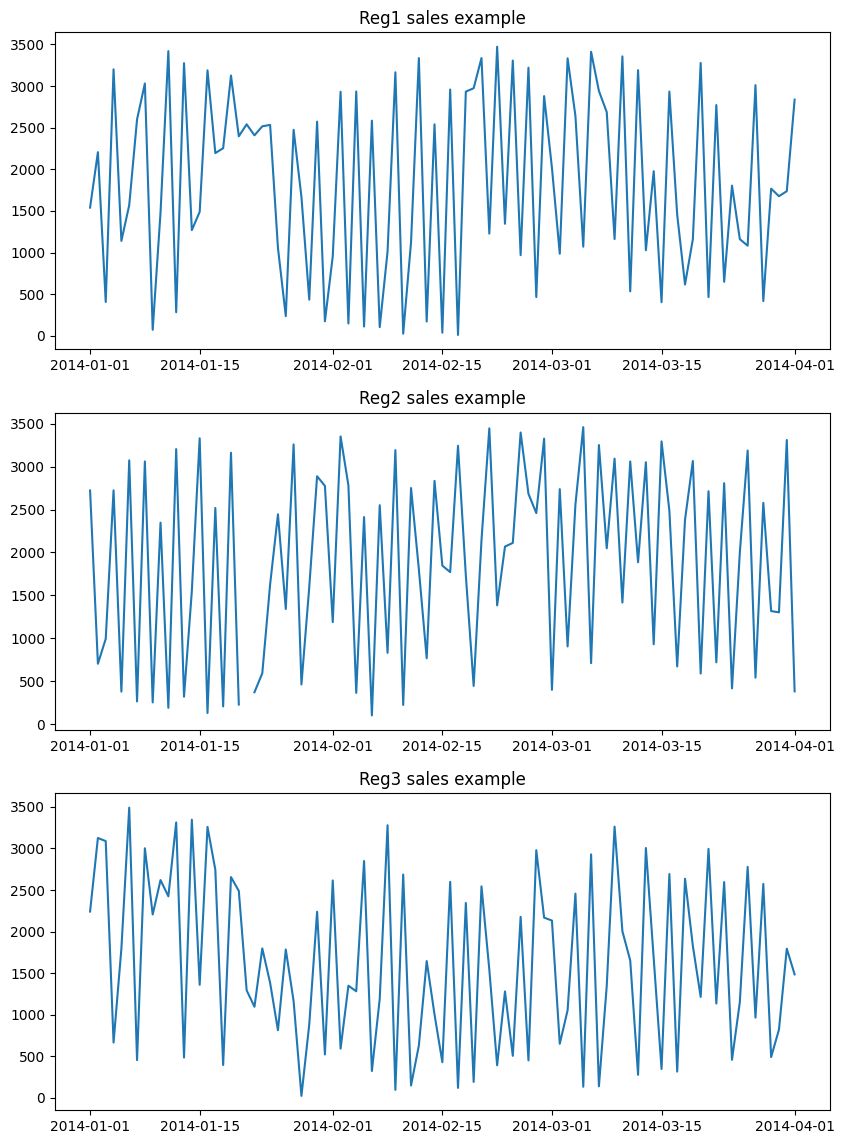

In [6]:
#plotting sales in 3 regions from 01-01-2014 to 01-06-2014

fig, ax = plt.subplots(3, 1, figsize=(10, 14))

for i, region in enumerate(['Reg1', 'Reg2', 'Reg3']):
    dfi = df[(df['Date'] >= '2014-01-01') & (df['Date'] <= '2014-4-01') & (df['Region'] == region)].sort_values('Date')
    ax[i].plot(dfi['Date'], dfi['Sales'])
    ax[i].set_title(f'{region} sales example');

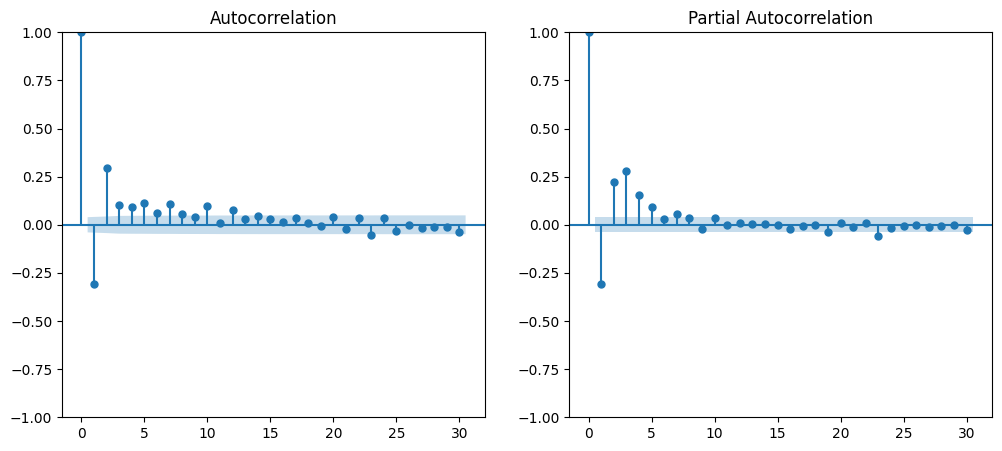

In [7]:
#plotting autocorrelation and correlation
from statsmodels.api import graphics

fig, ax = plt.subplots(1, 2, figsize=(12, 5))


_z = df[df['Region'] == 'Reg1']['Sales'].fillna(1000.0).values.squeeze()
graphics.tsa.plot_acf(_z, ax=ax[0], lags=30)
graphics.tsa.plot_pacf(_z, ax=ax[1], lags=30, method='ywm');

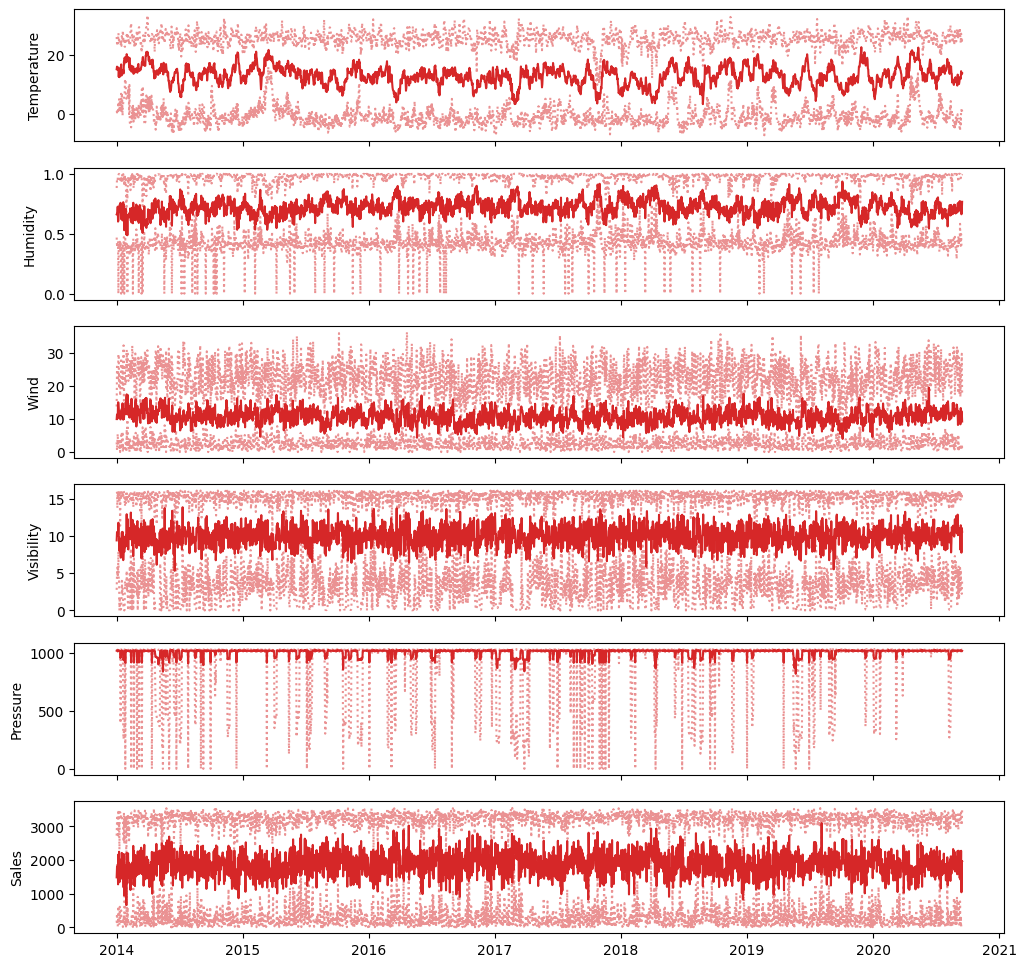

In [8]:
# plotting average minimum and maximum for features
# max and minimun is plotted with dotted line wheras mean is plotted with solid line
features = ['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']

fig, ax = plt.subplots(len(features), 1, figsize=(12, 2 * len(features)), sharex='all')
for i, var in enumerate(features):
    var_mean = df.groupby('Date')[var].mean()
    var_min = df.groupby('Date')[var].min()
    var_max = df.groupby('Date')[var].max()

    ax[i].plot(var_mean.index, var_mean, color="tab:red", linestyle="-")
    ax[i].plot(var_min.index, var_min, color="tab:red", linestyle=":", alpha=0.5)
    ax[i].plot(var_max.index, var_max, color="tab:red", linestyle=":", alpha=0.5)
    ax[i].set_ylabel(var)

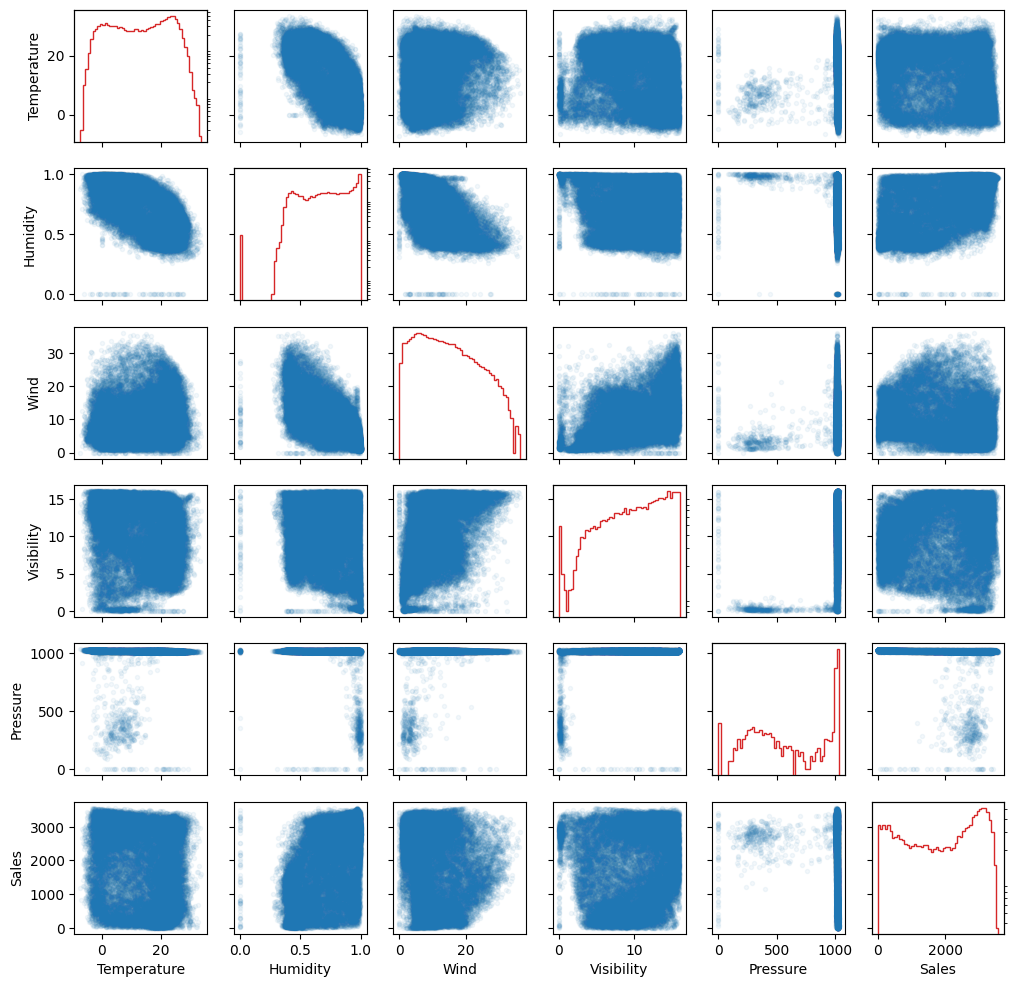

In [9]:
fig, ax = plt.subplots(len(features), len(features), figsize=(2 * len(features), 2 * len(features)), sharex='col', sharey='row')

for i, f_i in enumerate(features):
    for j, f_j in enumerate(features):
        if i == j:
            ax_x = ax[i, j].twinx()
            ax_x.hist(df[f_i], 50, density=True, histtype='step', color='tab:red')
            ax_x.set_yscale('log')
            ax_x.set_yticks([])
            pass
        else:
            ax[i, j].scatter(df[f_j], df[f_i], color='tab:blue', marker='.', alpha=0.05)
        if i == len(features) - 1:
            ax[i, j].set_xlabel(f_j)
        if j == 0:
            ax[i, j].set_ylabel(f_i)

### Windowing data

In [10]:
LAG = 1
WSIZE = 14

features = ['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']
target = 'Sales'

res = utils.get_windowed_data(df, features, target, lag=LAG, window_size=WSIZE)
res.head()

,Region,Date,Temperature,Humidity,Wind,Visibility,Pressure,Sales,Target,TargetDate
0,Reg1,"[2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...","[17.471199, 15.48665982, 7.495189956, 8.621881...","[0.753878, 0.957388103, 0.816925228, 0.9526500...","[6.755839, 0.503179743, 5.716267431, 5.8019213...","[13.807525, 5.949231833, 9.644521475, 15.76032...","[1014.437661, 1012.246198, 1024.722764, 1016.7...","[1539.45, 2205.38, 405.83, 3200.5, 1139.66, 15...",1488.48,2014-01-15
1,Reg10,"[2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...","[26.17232282, 23.91709694, 24.28664572, 21.861...","[0.627922177, 0.405819893, 0.671113729, 0.4025...","[2.934501947, 9.160963238, 7.978232934, 11.281...","[2.767374629, 12.09907148, 12.57112255, 4.4618...","[1013.658047, 1021.791416, 1011.222222, 1023.7...","[879.4, 406.77, 2774.98, 23.83, 2442.87, 2626....",1034.04,2014-01-15
2,Reg2,"[2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...","[16.91972511, 18.88998845, 18.17460006, 20.612...","[0.768123806, 0.498119414, 0.435980201, 0.7458...","[9.974576735, 16.96058998, 24.22875637, 8.5814...","[9.930142373, 7.862271446, 13.74417146, 7.1583...","[1010.770295, 1018.639281, 1016.6527, 1009.578...","[2721.81, 701.96, 992.37, 2723.7, 377.47, 3073...",3330.37,2014-01-15
3,Reg3,"[2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...","[1.028776143, 1.591081474, 1.654484361, 0.1964...","[0.548460782, 0.542356551, 0.927872837, 0.8294...","[13.46098295, 25.75732462, 2.96212787, 5.49418...","[12.26504319, 15.49566808, 7.682969925, 8.8464...","[1022.632837, 1018.448307, 1020.261002, 1024.7...","[2240.22, 3125.15, 3087.19, 664.99, 1794.0, 34...",1359.04,2014-01-15
4,Reg4,"[2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...","[8.070674405, 14.80026769, 12.05405161, 15.181...","[0.632358909, 0.886672676, 0.644867063, 0.6795...","[13.2607568, 7.161245972, 11.10010086, 21.5553...","[6.628645101, 11.60574339, 8.48325879, 14.1103...","[1021.706718, 1010.401943, 1020.655487, 1010.7...","[468.78, 2644.56, 950.34, 2566.2, 1901.5, 2539...",2047.26,2014-01-15


### Formatting, splitting and preprocessing data

In [16]:
#stacking data to get 3 dimensional array(number of observations, time series length, number of features)
x = np.stack(res[features].apply(lambda x: np.stack(x, -1), axis=1).to_list())

#concatinating encoded region, month and weeday
z = np.concatenate([
    keras.backend.one_hot(res['Region'].astype('category').cat.codes, 10).numpy(), # one hot encoding for Region
    res['TargetDate'].dt.month.values.reshape(-1, 1), # month
    res['TargetDate'].dt.weekday.values.reshape(-1, 1) # weekday
], axis=1)

#target column
y = res['Target'].values

# considering all the data before 1-1-2019 as training data and after that as validation data
train_mask = res['TargetDate'] < pd.to_datetime('2019-01-01')

x_train = x[train_mask]
z_train = z[train_mask]
y_train = y[train_mask]

x_valid = x[~train_mask]
z_valid = z[~train_mask]
y_valid = y[~train_mask]

### Rescaling the data

In [17]:
x_train.shape

(18084, 14, 6)

In [18]:
z_train.shape

(18084, 12)

In [19]:
y_train.shape

(18084,)

In [21]:
#crating quantile transformation object with out distribution as normal
prepr_x = preprocessing.QuantileTransformer(output_distribution='normal')

#x_train is three dimensional data we need to reshape it before rescaling it
#as quantile transformation accepts 2 dimensional data
#and transforming it again to 3 dimensional array

#fit_transform for training data
x_train = prepr_x.fit_transform(x_train.reshape(x_train.shape[0], -1)).reshape(x_train.shape)

#transform for validation data
x_valid = prepr_x.transform(x_valid.reshape(x_valid.shape[0], -1)).reshape(x_valid.shape)


prepr_z = preprocessing.QuantileTransformer(output_distribution='normal')
z_train = prepr_z.fit_transform(z_train)
z_valid = prepr_z.transform(z_valid)

#as y is one dimensional array need to reshape it to rescale
prepr_y = preprocessing.QuantileTransformer(output_distribution='normal')
y_train = prepr_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_valid = prepr_y.transform(y_valid.reshape(-1, 1)).ravel()

### Baseline model (lightgbm)

Loss of complete model: 0.4521147339853036


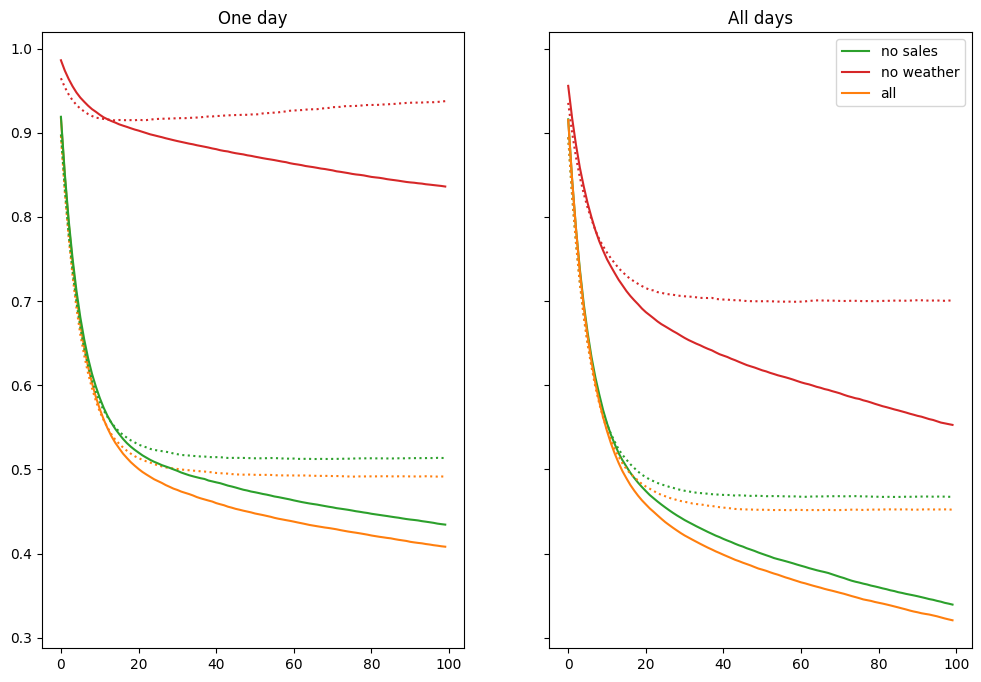

In [30]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(12, 8))

#creating object for lightgbm regressor model
baseline_model = lightgbm.LGBMRegressor(seed=42)

# Fitting model for latest day only
ax[0].set_title('One day')

## model fitted with All data
_x_train = np.concatenate([x_train[:, -1, :], z_train], 1)
_x_valid = np.concatenate([x_valid[:, -1, :], z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[0].plot(baseline_model.evals_result_['training']['l2'], color="C1", label='all')
ax[0].plot(baseline_model.evals_result_['valid_1']['l2'], color="C1", linestyle=':')

## model fitted Without sales data
_x_train = np.concatenate([x_train[:, -1, :-1], z_train], 1)
_x_valid = np.concatenate([x_valid[:, -1, :-1], z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[0].plot(baseline_model.evals_result_['training']['l2'], color="C2", label='no sales')
ax[0].plot(baseline_model.evals_result_['valid_1']['l2'], color="C2", linestyle=':')

## model fitted Without weather data
_x_train = np.concatenate([x_train[:, -1, -1:], z_train], 1)
_x_valid = np.concatenate([x_valid[:, -1, -1:], z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[0].plot(baseline_model.evals_result_['training']['l2'], color="C3", label='no weather')
ax[0].plot(baseline_model.evals_result_['valid_1']['l2'], color="C3", linestyle=':')

# Fitting model with all days in time window
ax[1].set_title('All days')

## Fittting model Without sales
_x_train = np.concatenate([x_train[:, :, :-1].reshape(x_train.shape[0], -1), z_train], 1)
_x_valid = np.concatenate([x_valid[:, :, :-1].reshape(x_valid.shape[0], -1), z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[1].plot(baseline_model.evals_result_['training']['l2'], color="C2", label='no sales')
ax[1].plot(baseline_model.evals_result_['valid_1']['l2'], color="C2", linestyle=':')

## Fitting model Without weather
_x_train = np.concatenate([x_train[:, :, -1:].reshape(x_train.shape[0], -1), z_train], 1)
_x_valid = np.concatenate([x_valid[:, :, -1:].reshape(x_valid.shape[0], -1), z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[1].plot(baseline_model.evals_result_['training']['l2'], color="C3", label='no weather')
ax[1].plot(baseline_model.evals_result_['valid_1']['l2'], color="C3", linestyle=':')

## Fitting modle with All data
_x_train = np.concatenate([x_train[:, :, :].reshape(x_train.shape[0], -1), z_train], 1)
_x_valid = np.concatenate([x_valid[:, :, :].reshape(x_valid.shape[0], -1), z_valid], 1)

baseline_model.fit(_x_train, y_train, eval_set=[(_x_train, y_train), (_x_valid, y_valid)], verbose=0)
ax[1].plot(baseline_model.evals_result_['training']['l2'], color="C1", label='all')
ax[1].plot(baseline_model.evals_result_['valid_1']['l2'], color="C1", linestyle=':')
_l2 = baseline_model.evals_result_['valid_1']['l2'][-1]

ax[1].legend()

print(f"Loss of complete model: {_l2}")

### Feature Importance

In [38]:
i = baseline_model.feature_importances_ / sum(baseline_model.feature_importances_)
print("Tabular features importances:" ,np.round(i[x_train.shape[1] * x_train.shape[2]:], 3))
print("Time series importances:")
pd.DataFrame(i[:x_train.shape[1] * x_train.shape[2]].reshape(WSIZE, -1), columns=features).style.background_gradient(axis=None)

Tabular features importances: [0.    0.001 0.    0.    0.    0.    0.    0.001 0.001 0.001 0.003 0.002]
Time series importances:


,Temperature,Humidity,Wind,Visibility,Pressure,Sales
0,0.005667,0.008333,0.008667,0.006667,0.006333,0.008333
1,0.006000,0.006333,0.010333,0.008000,0.003000,0.006333
2,0.005333,0.005333,0.004000,0.007000,0.005667,0.005000
3,0.004667,0.007333,0.011333,0.006000,0.002667,0.008667
4,0.003333,0.004333,0.007333,0.007667,0.006000,0.009333
5,0.005667,0.009000,0.006000,0.006333,0.005000,0.007000
6,0.006000,0.006000,0.009000,0.006667,0.008667,0.005667
7,0.007667,0.005000,0.007667,0.007333,0.006333,0.013000
8,0.005000,0.008000,0.010333,0.009000,0.006667,0.010333
9,0.004667,0.008667,0.009000,0.009333,0.007000,0.005667


### LSTM model

Epoch 1/20
142/142 [==============================] - 12s 22ms/step - loss: 1.0395 - val_loss: 0.9421 - lr: 5.0000e-04
Epoch 2/20
142/142 [==============================] - 3s 19ms/step - loss: 0.8626 - val_loss: 0.6619 - lr: 4.9695e-04
Epoch 3/20
142/142 [==============================] - 3s 18ms/step - loss: 0.6259 - val_loss: 0.5341 - lr: 4.8789e-04
Epoch 4/20
142/142 [==============================] - 3s 19ms/step - loss: 0.5531 - val_loss: 0.5194 - lr: 4.7302e-04
Epoch 5/20
142/142 [==============================] - 3s 18ms/step - loss: 0.5266 - val_loss: 0.5075 - lr: 4.5273e-04
Epoch 6/20
142/142 [==============================] - 3s 18ms/step - loss: 0.5112 - val_loss: 0.4963 - lr: 4.2751e-04
Epoch 7/20
142/142 [==============================] - 3s 18ms/step - loss: 0.4970 - val_loss: 0.4965 - lr: 3.9798e-04
Epoch 8/20
142/142 [==============================] - 3s 18ms/step - loss: 0.4834 - val_loss: 0.4890 - lr: 3.6486e-04
Epoch 9/20
142/142 [==============================] - 3

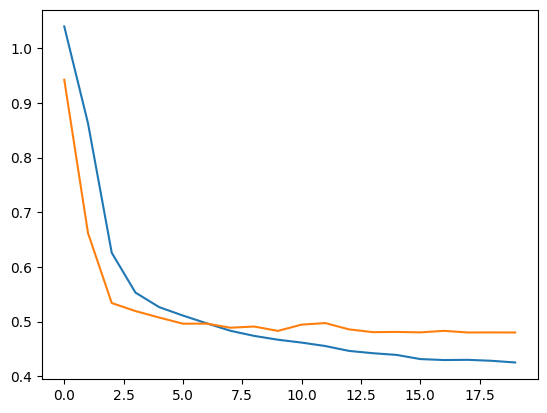

In [16]:
#clearning backend session
keras.backend.clear_session()
tf.keras.backend.set_image_data_format("channels_last") # necessary on sagemaker

#random seed to get less variablity for each run of the code
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

# taking input as time series dataset and returning tabular format dataset
# conversion from three dimensional with 2 dimensional data

ts_model = keras.Sequential([

    #replacing null values with 0
    keras.layers.Lambda(lambda x: tf.where(tf.math.is_nan(x), -0., x)),
    
    keras.layers.Conv1D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    
    keras.layers.Conv1D(64, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    
    keras.layers.LSTM(64, return_sequences=True),
    
    keras.layers.GlobalAveragePooling1D()
])
tb_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

X = keras.layers.Input(shape=(None, x_train.shape[2]))
Z = keras.layers.Input(shape=(z_train.shape[1],))

E = keras.backend.concatenate([Z, ts_model(X)], axis=1)
P = tb_model(E)

#creating keras model with input (X, Z) and output P
model = keras.Model(inputs=(X, Z), outputs=P)

# considering loss as MSE and Adam optimizer
# if the value of norm of gradient is greater than 1 then it would be taken as 1 due to clipnorm
# to avoid big gradients causing unstable training
model.compile(loss='mse', optimizer=keras.optimizers.Adam(clipnorm=1.0))

callbacks = [keras.callbacks.LearningRateScheduler(keras.optimizers.schedules.CosineDecay(5e-4, 20, 0.01))]

#fitting the model
history = model.fit((x_train, z_train), y_train, validation_data=((x_valid, z_valid), y_valid), epochs=20, batch_size=128, callbacks=callbacks)

#plotting loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

### Predict one day into the future

In [17]:
import datetime


def predict_one(day, region):
    """
    Function to predict for next day using the trained model

    Input: 
    day: Date to predict
    region: Region to predict

    Output:
    y_pred_new: predictions from the model(scaled values)
    y_pred_inv_new: actual values of prediction(rescaled to the original values )
    
    """

    #creating z_new data
    z_new = np.concatenate([
        (res['Region'].astype('category').cat.categories == region).astype(float),
        np.array([day.month]),
        np.array([day.weekday()])
    ]).reshape((1, -1))
    x_new = df[(df['Region'] == region) & (df['Date'] >= df['Date'].max() - datetime.timedelta(days=WSIZE - 1))][features].values.reshape(1, WSIZE, -1)

    x_new = prepr_x.transform(x_new.reshape(1, -1)).reshape(1, WSIZE, len(features))
    z_new = prepr_z.transform(z_new)
    
    y_pred_new = model.predict([x_new, z_new], verbose=0)
    y_pred_inv_new = prepr_y.inverse_transform(y_pred_new)
    
    return y_pred_new, y_pred_inv_new
    


day = df['Date'].max() + datetime.timedelta(days=1)
for region in df['Region'].unique():
    y_pred_new, y_pred_inv_new = predict_one(day, region)
    print("%5s\t|\t%.4f\t|\t%.0f" % (region, y_pred_new[0, 0], y_pred_inv_new[0, 0]))

 Reg1	|	-0.2452	|	1558
Reg10	|	-0.4927	|	1128
 Reg2	|	0.2890	|	2522
 Reg3	|	-0.9049	|	589
 Reg4	|	-1.2003	|	343
 Reg5	|	-0.7493	|	759
 Reg6	|	-0.7473	|	761
 Reg7	|	0.7891	|	2976
 Reg8	|	0.4677	|	2724
 Reg9	|	-1.1374	|	383


### Save model & Create endpoint

In [18]:
# save the model and put it in a tar.gz
model.save("model_save/01")

with tarfile.open("model_save.tar.gz", mode='w:gz') as arx:
    arx.add("model_save/01", recursive=True)

INFO:tensorflow:Assets written to: model_save/01\assets


INFO:tensorflow:Assets written to: model_save/01\assets


In [19]:
import boto3

s3 = boto3.resource('s3')
s3_bucket = s3.Bucket('amedeo-burger-lstm')
s3_bucket.upload_file("model_save.tar.gz", "model_save.tar.gz")

S3UploadFailedError: Failed to upload model_save.tar.gz to amedeo-burger-lstm/model_save.tar.gz: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

In [ ]:
# random data, just for an example
x_sample = x_valid[:10]
z_sample = z_valid[:10]

In [21]:
# remember to preprocess the data if needed, in our case we already did previously
# QuantileTransformer (or other preprocessing classes) can be stored into S3 to be easiliy available!
# simply save the object to a pickle and use the s3_bucket.upload_file(filename.pkl, filename.pkl) to upload it to your S3 bucket!
# you will be able to download it using s3_bucket.download_file(filename.pkl, filename.pkl)


# taking all the object used in rescaling and uploading them on s3 for further use
import pickle

for name, obj in {
    'prepr_x': prepr_x,
    'prepr_z': prepr_z,
    'prepr_y': prepr_y
}.items():
    
    local_pkl_name = f"{name}_original.pkl"

    with open(local_pkl_name, "wb") as f:
        pickle.dump(obj, f)

    s3_bucket.upload_file(local_pkl_name, f"{name}_inside_s3.pkl")
    
    os.remove(local_pkl_name)

# the next part can be run in another notebook/script...

#s3_bucket.download_file("prepr_x_inside_s3.pkl", "prepr_x_from_s3.pkl")

#prep_x_from_s3 = pickle.load(open("prepr_x_from_s3.pkl", "rb"))

# now you can use it freely
# we don't need since x_sample and z_sample
# remember also to run prepr_y.inverse_transform on the output if needed

In [22]:
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel

sagemaker_model = TensorFlowModel(
    model_data = f"s3://amedeo-burger-lstm/model_save.tar.gz",
    role = sagemaker.get_execution_role(),
    framework_version = tf.__version__,
    entry_point = 'empty_train.py'
)

#creating an endpoint
endpoint = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

print("\n", endpoint.endpoint_name)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!
 tensorflow-inference-2022-11-09-19-20-39-621


In [23]:
# predict from endpoint
out = endpoint.predict({
    'inputs': {
        'input_1': x_sample.tolist(),
        'input_2': z_sample.tolist(),
    }
})

out

{'outputs': [[0.245624289],
  [-1.28556168],
  [0.987347543],
  [0.0897313282],
  [-0.0497341566],
  [0.779102504],
  [-1.29154634],
  [-0.310508579],
  [0.0240165479],
  [0.196907043]]}

In [24]:
#local predictions
model.predict([x_sample, z_sample]) # the same!

array([[ 0.24562429],
       [-1.2855617 ],
       [ 0.98734766],
       [ 0.08973134],
       [-0.04973417],
       [ 0.77910256],
       [-1.2915463 ],
       [-0.31050858],
       [ 0.02401658],
       [ 0.19690704]], dtype=float32)

In [25]:
#transforming the output
print("Transformed output")
prepr_y.inverse_transform(np.array(out['outputs']))

Transformed output


array([[2461.14462106],
       [ 297.90273947],
       [3082.40347654],
       [2212.15629095],
       [1950.05687415],
       [2970.78082725],
       [ 294.80833766],
       [1438.86198676],
       [2088.01280633],
       [2394.28269789]])

In [26]:
# remember to delete the endpoint when it is no longer needed!
endpoint.delete_endpoint()